In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

import bayesflow as bf
from bayesflow.amortizers import AmortizedPointEstimator
from bayesflow.benchmarks import Benchmark
from bayesflow.helper_networks import ConfigurableMLP
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.summary_networks import DeepSet

np.random.seed(2024)


In [13]:
#先验分布
# 定义Inverse Gamma先验分布
def batch_prior_fun(batch_size):
    
    # 定义 miu 的先验: N(mean, stddev)
    mean, stddev = 0.0, 1.0
    miu_dist = tfp.distributions.Normal(loc=mean, scale=stddev)
    miu_samples = miu_dist.sample((batch_size, 1))   
    
    # 定义 sigma^2 的先验: InverseGamma(alpha, beta)
    alpha, beta = 2.0, 1.0  # 推荐参数
    sigma2_dist = tfp.distributions.InverseGamma(concentration=alpha, scale=beta)
    sigma2_samples = sigma2_dist.sample((batch_size, 1))

    # 返回 miu 和 sigma^2 的样本
    return miu_samples,sigma2_samples

# 定义模拟器
def batch_simulator_fun(miu_sigma2, n_obs=1000):
    miu = miu_sigma2[0]
    sigma2 = miu_sigma2[1]
    # 使用 miu 和 sigma^2 生成观测值，假设 Y ~ N(miu, sqrt(sigma^2))
    return tf.random.normal(
        (miu.shape[0], n_obs), mean=miu, stddev=tf.sqrt(sigma2)
    )[:, :, None]


# prior = Prior(batch_prior_fun=batch_prior_fun)
# simulator = Simulator(batch_simulator_fun=batch_simulator_fun)
# generative_model = GenerativeModel(prior=prior, simulator=simulator)

In [14]:
from bayesflow.amortizers import AmortizedPointEstimator
from bayesflow.helper_networks import ConfigurableMLP

prior = Prior(batch_prior_fun=batch_prior_fun)
simulator = Simulator(batch_simulator_fun=batch_simulator_fun)
generative_model = GenerativeModel(prior=prior, simulator=simulator)

# 定义推断网络
summary_dim = 10
summary_net = DeepSet(summary_dim)

inference_net = ConfigurableMLP(input_dim=summary_dim, output_dim=2, dropout_rate=0.1)

amortizer = AmortizedPointEstimator(inference_net, summary_net=summary_net, norm_ord=1)


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [15]:
# 定义配置器
def config(forward_dict):
    """Helper function for posterior configuration."""
    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"]
    input_dict["summary_conditions"] = forward_dict["sim_data"]
    return input_dict


# 定义Trainer
from bayesflow.trainers import Trainer
trainer = Trainer(
    amortizer=amortizer,
    configurator=config,
    generative_model=generative_model
)

# 开始训练
h = trainer.train_online(1, 500, batch_size=32)


INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
Training epoch 1: 100%|██████████| 500/500 [00:27<00:00, 18.14it/s, Epoch: 1, Iter: 500,Loss: 1.068,Avg.Loss: 1.337,LR: 4.93E-09]


In [9]:
# 定义测试数据
num_test = 1000

# 定义测试时的参数生成函数
# 对于测试，miu 固定为 1.0，sigma^2 固定为 4.0
test_param_fun = lambda batch_size: (tf.ones((batch_size, 1)) * 0,  # miu = 0.2
                                     tf.ones((batch_size, 1)) * 1.0)  # sigma^2 = 1.0

# 使用修改后的 GenerativeModel
test_model = GenerativeModel(prior=Prior(batch_prior_fun=test_param_fun), simulator=simulator)

# 生成测试数据
test_data = config(test_model(num_test))


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [10]:
estimated_values = amortizer.estimate(test_data)

In [84]:
estimated_miu = estimated_values[:, 0]
estimated_sigma = estimated_values[:, 1]

In [85]:
def bayes_estimator_mu(Z, mu_0=0, kappa_0=1, alpha_0=2, beta_0=1):
    """
    贝叶斯估计器：根据观测数据计算正态-逆伽马分布的后验参数，并分别采样 mu 和 sigma。
    
    参数：
    - Z: 输入数据，形状为 TensorShape([n, 1])。
    - mu_0: 先验均值。
    - kappa_0: 先验样本量。
    - alpha_0: Inverse-Gamma 分布的初始形状参数。
    - beta_0: Inverse-Gamma 分布的初始尺度参数。
    
    返回：
    - posterior_samples_mu: 从后验分布采样的均值 (mu)。
    - posterior_samples_sigma: 从后验分布采样的标准差 (sigma)。
    """
    # 确保 Z 是 TensorFlow 张量
    Z = tf.convert_to_tensor(Z, dtype=tf.float32)

    # 计算观测数据的统计量
    n = tf.cast(Z.shape[0], tf.float32)  # 样本数量
    z_bar = tf.reduce_mean(Z)  # 样本均值
    S = tf.reduce_sum(tf.square(Z - z_bar))  # 样本的平方和

    # 更新后验参数
    kappa_n = kappa_0 + n
    mu_n = (kappa_0 * mu_0 + n * z_bar) / kappa_n
    alpha_n = alpha_0 + n / 2
    beta_n = beta_0 + S / 2 + (kappa_0 * n * tf.square(z_bar - mu_0)) / (2 * kappa_n)

    # 采样 sigma^2 从 Inverse-Gamma 后验分布
    dist_sigma2 = tfp.distributions.InverseGamma(concentration=alpha_n, scale=beta_n)
    posterior_samples_sigma2 = dist_sigma2.sample(1000).numpy()

    # 计算 sigma，并从后验分布中采样
    posterior_samples_sigma = np.sqrt(posterior_samples_sigma2)

    # 采样 mu 从后验正态分布
    dist_mu = tfp.distributions.Normal(loc=mu_n, scale=tf.sqrt(1/(kappa_0+n)))
    posterior_samples_mu = dist_mu.sample(1000).numpy()

    return posterior_samples_mu

# # summary_conditions = tf.reshape(test_data["summary_conditions"], [-1, 1])
# summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])
# 
# # 调用 bayes_estimator
# reference = bayes_estimator_mu(summary_conditions)

reference = bayes_estimator_mu(test_data["summary_conditions"])


/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_24406/2292901551.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prior_samples, label="Prior for Miu", shade=True)


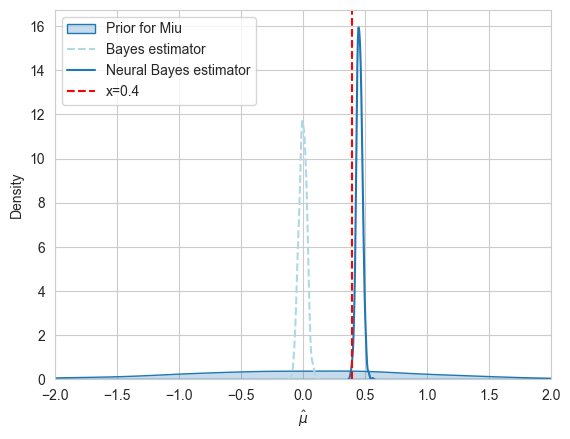

In [86]:
# 定义miu的先验分布为逆伽马分布
prior_dist = tfp.distributions.Normal(0.0, 1.0)

# 从该分布中采样 1000 个点
prior_samples = prior_dist.sample(1000).numpy()

# 绘制先验分布
sns.kdeplot(prior_samples, label="Prior for Miu", shade=True)
sns.kdeplot(reference, label="Bayes estimator", color="lightblue", linestyle="--")
sns.kdeplot(estimated_miu, label="Neural Bayes estimator")
plt.axvline(x=0.4, color="red", linestyle="--", linewidth=1.5, label="x=0.4")

plt.xlim(-2, 2)

plt.xlabel(r"$\hat\mu$")

_ = plt.legend()

In [61]:
def bayes_estimator_sigma(Z, mu_0=0, kappa_0=1, alpha_0=2, beta_0=1):
    """
    贝叶斯估计器：根据观测数据计算正态-逆伽马分布的后验参数，并分别采样 mu 和 sigma。
    
    参数：
    - Z: 输入数据，形状为 TensorShape([n, 1])。
    - mu_0: 先验均值。
    - kappa_0: 先验样本量。
    - alpha_0: Inverse-Gamma 分布的初始形状参数。
    - beta_0: Inverse-Gamma 分布的初始尺度参数。
    
    返回：
    - posterior_samples_mu: 从后验分布采样的均值 (mu)。
    - posterior_samples_sigma: 从后验分布采样的标准差 (sigma)。
    """
    # 确保 Z 是 TensorFlow 张量
    Z = tf.convert_to_tensor(Z, dtype=tf.float32)

    # 计算观测数据的统计量
    n = tf.cast(Z.shape[0], tf.float32)  # 样本数量
    z_bar = tf.reduce_mean(Z)  # 样本均值
    S = tf.reduce_sum(tf.square(Z - z_bar))  # 样本的平方和

    # 更新后验参数
    kappa_n = kappa_0 + n
    mu_n = (kappa_0 * mu_0 + n * z_bar) / kappa_n
    alpha_n = alpha_0 + n / 2
    beta_n = beta_0 + S / 2 + (kappa_0 * n * tf.square(z_bar - mu_0)) / (2 * kappa_n)

    # 采样 sigma^2 从 Inverse-Gamma 后验分布
    dist_sigma2 = tfp.distributions.InverseGamma(concentration=alpha_n, scale=beta_n)
    posterior_samples_sigma2 = dist_sigma2.sample(1000).numpy()

    # 计算 sigma，并从后验分布中采样
    posterior_samples_sigma = np.sqrt(posterior_samples_sigma2)

    # 采样 mu 从后验正态分布
    dist_mu = tfp.distributions.Normal(loc=mu_n, scale=tf.sqrt(1/(kappa_0+n)))
    posterior_samples_mu = dist_mu.sample(1000).numpy()

    return posterior_samples_sigma

# summary_conditions = tf.reshape(test_data["summary_conditions"], [-1, 1])
summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])

# 调用 bayes_estimator
reference = bayes_estimator_sigma(summary_conditions)


/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_24406/3965044930.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prior_samples, label="Prior for Sigma", shade=True)


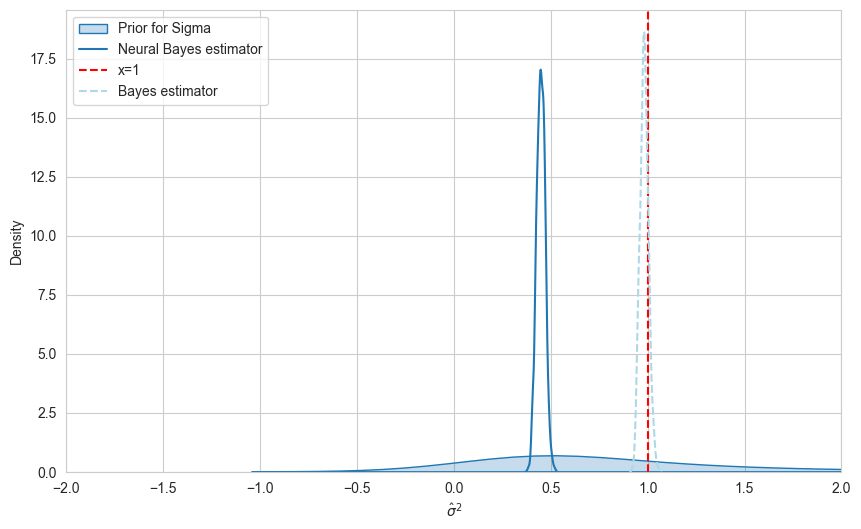

In [62]:
# 定义sigma的先验分布为逆伽马分布
prior_dist = tfp.distributions.InverseGamma(2.0, 1.0)

# 从该分布中采样 1000 个点
prior_samples = prior_dist.sample(1000).numpy()

# 创建绘图
plt.figure(figsize=(10, 6))
sns.kdeplot(prior_samples, label="Prior for Sigma", shade=True)
sns.kdeplot(estimated_sigma, label="Neural Bayes estimator")
plt.axvline(x=1, color="red", linestyle="--", linewidth=1.5, label="x=1")
sns.kdeplot(reference, label="Bayes estimator", color="lightblue", linestyle="--")

# 设置横坐标限制
plt.xlim(-2, 2)

# 添加标签和图例
plt.xlabel(r"$\hat\sigma^2$")
_ = plt.legend()

# 显示图形
plt.show()
